In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# import scipy
# from netcal.metrics import ECE, ACE

from dataloader import get_dataloaders
from models.msdnet_ge import MSDNet
from models.msdnet_imta import IMTA_MSDNet
from utils import parse_args
from utils_notebook import f_probs_ovr_poe_logits_weighted, modal_probs_decreasing

from collections import OrderedDict, Counter
import random
from typing import Dict

In [23]:
MODEL = "model1"
IMTA = True


if IMTA:
    MODEL += "_IMTA"
    EPOCH = "170"
else:
    EPOCH = "299"

## 0 Load pretrained model

In [24]:
# CIFAR-100 GE
ARGS = parse_args()
ARGS.data_root = 'data'
ARGS.data = 'cifar100'
ARGS.save= f'/home/metod/Desktop/PhD/year1/PoE/IMTA/_models/{ARGS.data}/{MODEL}'
if IMTA:
    ARGS.arch = 'IMTA_MSDNet'
else:
    ARGS.arch = 'msdnet_ge'
ARGS.grFactor = [1, 2, 4]
ARGS.bnFactor = [1, 2, 4]
ARGS.growthRate = 6
ARGS.batch_size = 64
ARGS.epochs = 300
ARGS.nBlocks = 7
ARGS.stepmode = 'even'
ARGS.base = 4
ARGS.nChannels = 16
ARGS.num_classes = 100
ARGS.step = 2
ARGS.use_valid = True
ARGS.splits = ['train', 'val', 'test']
ARGS.nScales = len(ARGS.grFactor)

if IMTA:
    ARGS.T = 1.0
    ARGS.gamma = 0.1
    _MODEL = MODEL.replace("_IMTA", "")
    ARGS.pretrained = f'/home/metod/Desktop/PhD/year1/PoE/IMTA/_models/{ARGS.data}/{_MODEL}/save_models/model_best.pth.tar'

In [25]:
problematic_prefix = 'module.'

# load pre-trained model
if IMTA:
    model = IMTA_MSDNet(args=ARGS)
else:
    model = MSDNet(args=ARGS)
MODEL_PATH = f'_models/{ARGS.data}/{MODEL}/save_models/checkpoint_{EPOCH}.pth.tar'
# MODEL_PATH = f'_models/{ARGS.data}/{MODEL}/save_models/model_best.pth.tar'  # TODO: investigate why using this results in poor accuracy of baseline model
print(MODEL_PATH)
state = torch.load(MODEL_PATH)
params = OrderedDict()
for params_name, params_val in state['state_dict'].items():
    if params_name.startswith(problematic_prefix):
        params_name = params_name[len(problematic_prefix):]
    params[params_name] = params_val
model.load_state_dict(params)
model = model.cuda()
model.eval()

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

IMTA_MSDNet(
  (net): WrappedModel(
    (module): MSDNet(
      (blocks): ModuleList(
        (0): Sequential(
          (0): MSDNFirstLayer(
            (layers): ModuleList(
              (0): ConvBasic(
                (net): Sequential(
                  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (2): ReLU(inplace=True)
                )
              )
              (1): ConvBasic(
                (net): Sequential(
                  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
                  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (2): ReLU(inplace=True)
                )
              )
              (2): ConvBasic(
                (net): Sequential(
                  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2

In [26]:
# data
_, _, test_loader = get_dataloaders(ARGS)

logits = []
targets = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        y = y.cuda(device=None)
        x = x.cuda()

        input_var = torch.autograd.Variable(x)
        target_var = torch.autograd.Variable(y)

        if IMTA:
            output = model(input_var)
        else:
            output, _ = model(input_var)

        if not isinstance(output, list):
            output = [output]

        logits.append(torch.stack(output))
        targets.append(target_var)

logits = torch.cat(logits, dim=1).cpu()
targets = torch.cat(targets).cpu()

Files already downloaded and verified
Files already downloaded and verified
!!!!!! Load train_set_index !!!!!!
------------------------------------
split num_sample_valid: 5000
------------------------------------


## 1 Anytime performance

In [27]:
L = len(logits)
N = logits.shape[1]

In [28]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [29]:
acc

[tensor(0.6274),
 tensor(0.6742),
 tensor(0.7029),
 tensor(0.7160),
 tensor(0.7211),
 tensor(0.7240),
 tensor(0.7217)]

In [30]:
probs_poe_ovr_break_ties = torch.tensor(f_probs_ovr_poe_logits_weighted(logits))
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

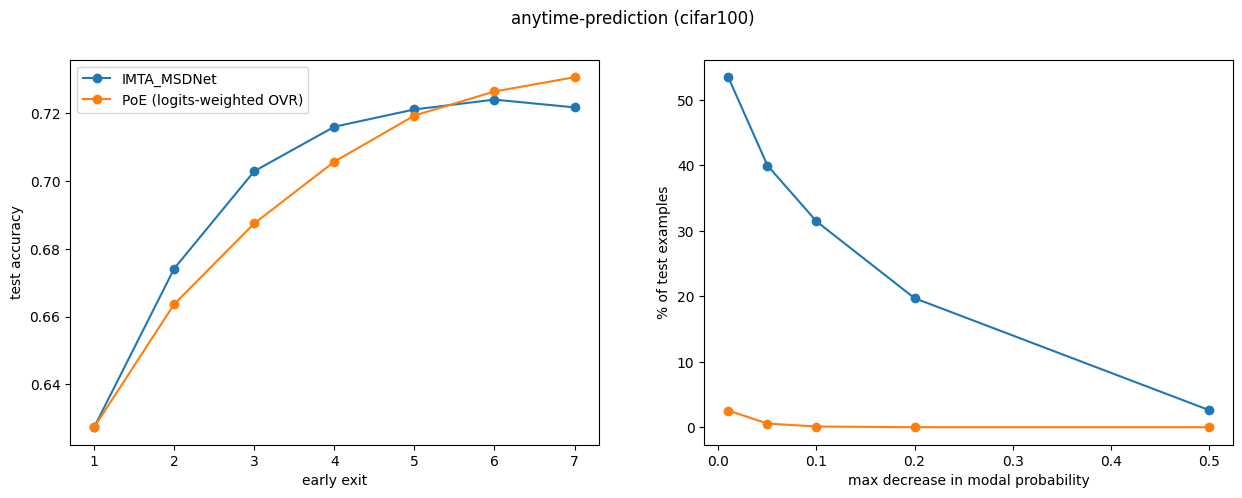

In [31]:
early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(early_exits, acc, label=f'{ARGS.arch}', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='PoE (logits-weighted OVR)', marker='o')
ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _probs, label in [
                            (preds, probs, f'{ARGS.arch}'), 
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (logits-weighted OVR)'),
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, L)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
# ax[1].legend()
# ax[1].set_title('anytime-prediction')
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle(f'anytime-prediction ({ARGS.data})')
plt.show()